In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

import seaborn as sns

from datetime import datetime
saving_prefix = datetime.now().replace(microsecond=0).isoformat()
saving_prefix = str(Path('.') / "figs" / saving_prefix)

In [16]:
results_dir = Path("/home/alexander/projects/car_data_analysis/second_results")
results= dict()
results["test"] = results_dir.glob("*_test.csv")
results["train"] = results_dir.glob("*_train.csv")
results["runtimes"] = results_dir.glob("*_runtimes.csv")

for key in results:
    tmp = pd.DataFrame()
    for file in results[key]:
        method = file.stem.split("_")[0]
        method_results = pd.read_csv(file, )
        method_results["method"] = method
        tmp = pd.concat((tmp, method_results))
    results[key] = tmp

In [17]:
print(len(results["test"]))
results["test"].head()

1839200


,id,price,prediction,test,exp,method
0,151-25,5994,4670.7666,1,0,NN
1,159-208,9700,11058.7210,1,0,NN
2,149-293,4650,5759.1540,1,0,NN
3,24-378,2999,3526.2485,1,0,NN
4,8-283,4207,6192.1416,1,0,NN


In [18]:
results["train"].head()

,id,price,prediction,test,exp,method
0,0-0,800,-508.021327,0,0,LM
1,0-100,850,1727.076057,0,0,LM
2,0-103,795,614.395162,0,0,LM
3,0-104,995,1070.730908,0,0,LM
4,0-105,1000,313.990027,0,0,LM


In [19]:
results["runtimes"].head()

,seconds,method
0,3,GLM
1,3,GLM
2,6,GLM
3,3,GLM
4,2,GLM


## Runtimes

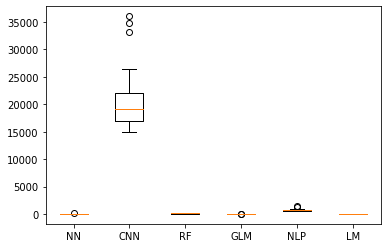

In [20]:
rts = results["runtimes"]
methods = set(results["runtimes"]["method"].values)
methods = list(methods)
vals = [rts[rts["method"] == method]["seconds"] for method in methods]

plt.boxplot(vals, labels=methods)
plt.savefig(saving_prefix + "_runtimes_w_cnn.png")

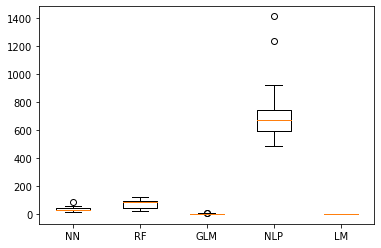

In [21]:
rts = rts[rts["method"] != "CNN"]
m = [x for x in methods if x != "CNN"]
vals = [rts[rts["method"] == method]["seconds"] for method in m]

plt.boxplot(vals, labels=m)
plt.savefig(saving_prefix + "_runtimes.png")

## Metrics by method on test set

In [22]:
grouped = results["test"].groupby(["method","exp"])

def _r_sq(y_true, y_pred):
    SST = sum((y_true-y_true.mean())**2)
    SSR = sum((y_true-y_pred)**2)
    return (1 - SSR/SST)

def _mse(y_true, y_pred):
    return sum((y_true - y_pred)**2)/len(y_pred)

def _mae(y_true, y_pred):
    return sum(abs(y_true - y_pred))/len(y_pred)
    

mse = grouped.apply(lambda x: _mse(x["price"], x["prediction"]) )
mae = grouped.apply(lambda x: _mae(x["price"], x["prediction"]) )
rsq = grouped.apply(lambda x: _r_sq(x["price"], x["prediction"]) )
print(mse, mae, rsq)

method  exp
CNN     0      7.488906e+06
        1      7.592939e+06
        2      7.600232e+06
        3      7.654076e+06
        4      7.409195e+06
                   ...     
RF      23     1.556470e+06
        24     1.556164e+06
        25     1.547580e+06
        26     1.600186e+06
        27     1.547420e+06
Length: 176, dtype: float64 method  exp
CNN     0      2288.753799
        1      2293.825077
        2      2268.858973
        3      2298.725074
        4      2283.958708
                  ...     
RF      23      922.985411
        24      930.000260
        25      926.583786
        26      927.337304
        27      924.471226
Length: 176, dtype: float64 method  exp
CNN     0      0.117126
        1      0.114010
        2      0.103950
        3      0.086147
        4      0.121722
                 ...   
RF      23     0.816763
        24     0.819663
        25     0.818644
        26     0.811827
        27     0.815752
Length: 176, dtype: float64


In [23]:
metrics = {
    'mse' : {'mean':mse.mean(level="method"), 'std':mse.std(level="method")},
    'mae' : {'mean':mae.mean(level="method"), 'std':mae.std(level="method")},
    'rsq' : {'mean':rsq.mean(level="method"), 'std':rsq.std(level="method")},
}
metrics['mae']

{'mean': method
 CNN    2294.798218
 GLM    1109.251263
 LM     1170.699279
 NLP    1779.650944
 NN     1020.863712
 RF      927.493036
 dtype: float64,
 'std': method
 CNN    28.014200
 GLM     6.544800
 LM      6.575131
 NLP    13.509758
 NN     11.471606
 RF      8.594805
 dtype: float64}

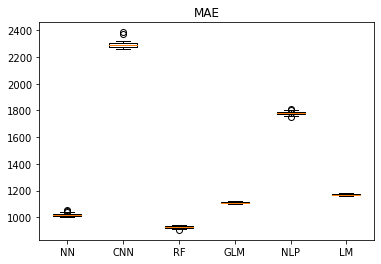

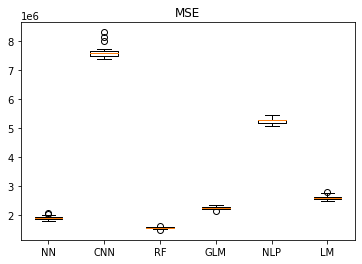

In [24]:
for metric, vals in [("MAE", mae), ("MSE", mse)]:
    plt.figure()
    methods = list(methods)
    mae_perf = [vals.loc[method].values for method in methods]
    plt.title(metric)
    plt.boxplot(mae_perf, labels=methods)
    plt.savefig(saving_prefix + f"_{metric}_comparison.png")

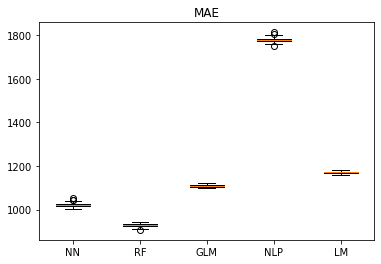

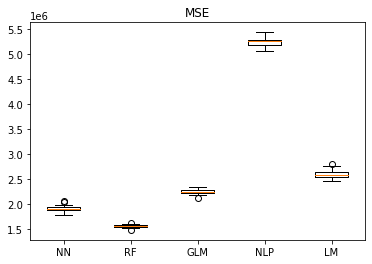

In [25]:
for metric, vals in [("MAE", mae), ("MSE", mse)]:
    plt.figure()
    methods = list(methods)
    m = [x for x in methods if x != "CNN"]
    mae_perf = [vals.loc[method].values for method in m]
    plt.title(metric)
    plt.boxplot(mae_perf, labels=m)
    plt.savefig(saving_prefix + f"_{metric}_comparison_no_cnn.png")

## Pairwise performance in test set

In [26]:
results["test"] = results["test"][results["test"]["price"]<11000]
pred_by_ad = results["test"].groupby(["method", "id"]).agg({
    "price":"mean",
    "prediction":"mean",
    "exp":"count"
})
#NOTE: average test prediction
pred_by_ad

price   prediction  exp
method id                            
CNN    0-0      800  6024.531050    8
       0-1      750  4200.677492   12
       0-10     795  5796.197470   10
       0-100    850  5902.983510   10
       0-101    799  5099.025400   10
...             ...          ...  ...
RF     99-93   6450  6813.652133    3
       99-94   6495  6498.511498    6
       99-95   6600  5111.568478    6
       99-98   6100  8015.717961    9
       99-99   6995  7582.590400   10

[205713 rows x 3 columns]

In [30]:
def plot(truth, preds, title):   
    fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,12))
    ax[0,0].hist2d(truth, preds, bins=50)
    ax[0,0].plot(truth, truth, color="white", label="Ideal")
    ax[0,0].legend()
    ax[0,0].set_xlabel("Truth")
    ax[0,0].set_ylabel("Prediction")
    ax[0,0].set_title("Confusion density")

    ax[0,1].scatter(truth, preds, color="red", alpha=0.2)
    ax[0,1].plot(truth, truth, color="black", label="Ideal")
    ax[0,1].legend()
    ax[0,1].set_xlabel("Truth")
    ax[0,1].set_title("Confusion scatter")
    
    _, bins, _ = ax[1,0].hist(truth, bins=50, alpha=0.4, label="Truth")
    ax[1,0].hist(preds, bins=bins, alpha=0.4, label="Pred")
    ax[1,0].legend()
    ax[1,0].set_xlabel("Price")
    ax[1,0].set_ylabel("Freq")
    ax[1,0].set_title("Price distribution")
    
    ax[1,1].hist(truth-preds, bins=50, alpha=0.4)
    ax[1,1].set_xlabel("Residual")
    ax[1,1].set_title("Residual distribution")

    fig.suptitle(title)
    fig.tight_layout()
    fig.savefig(saving_prefix + f"_{title}.png")
    

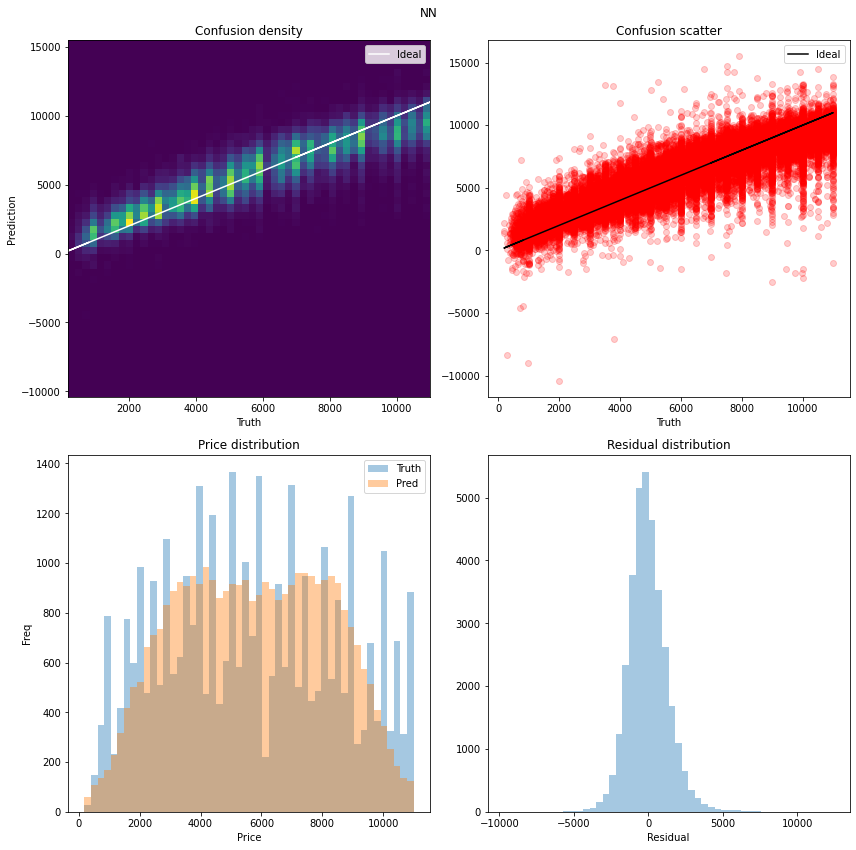

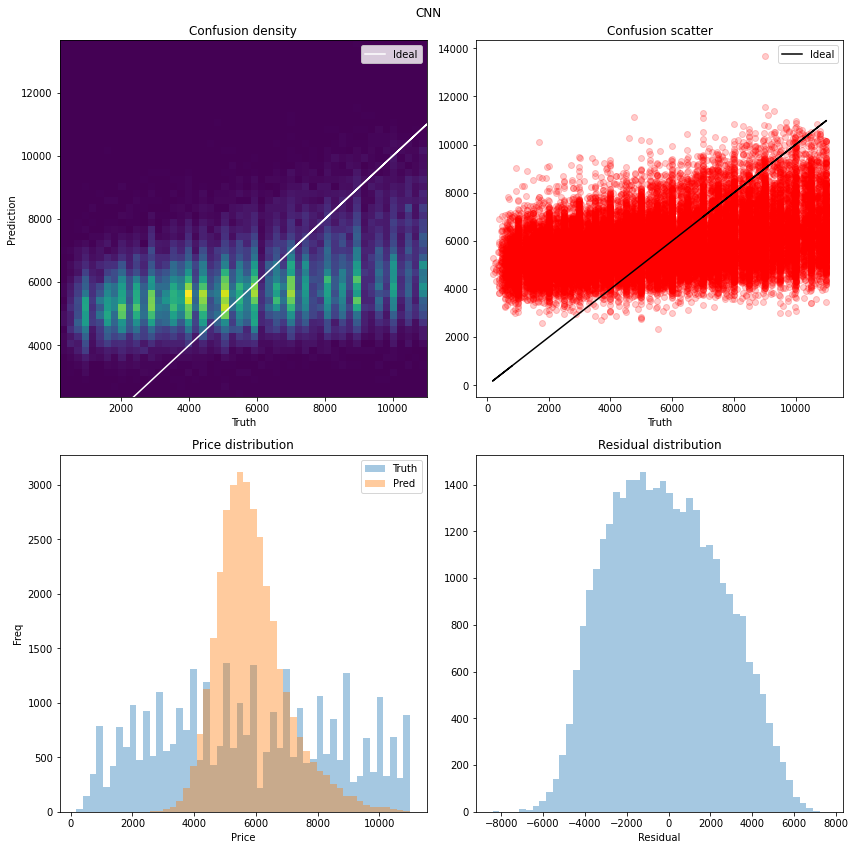

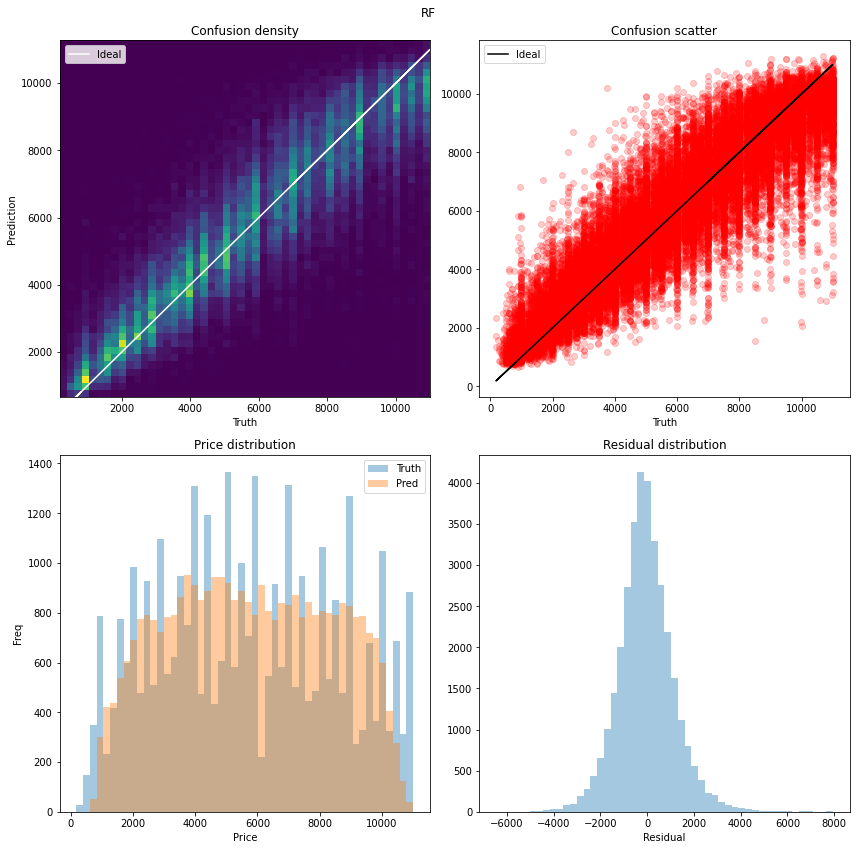

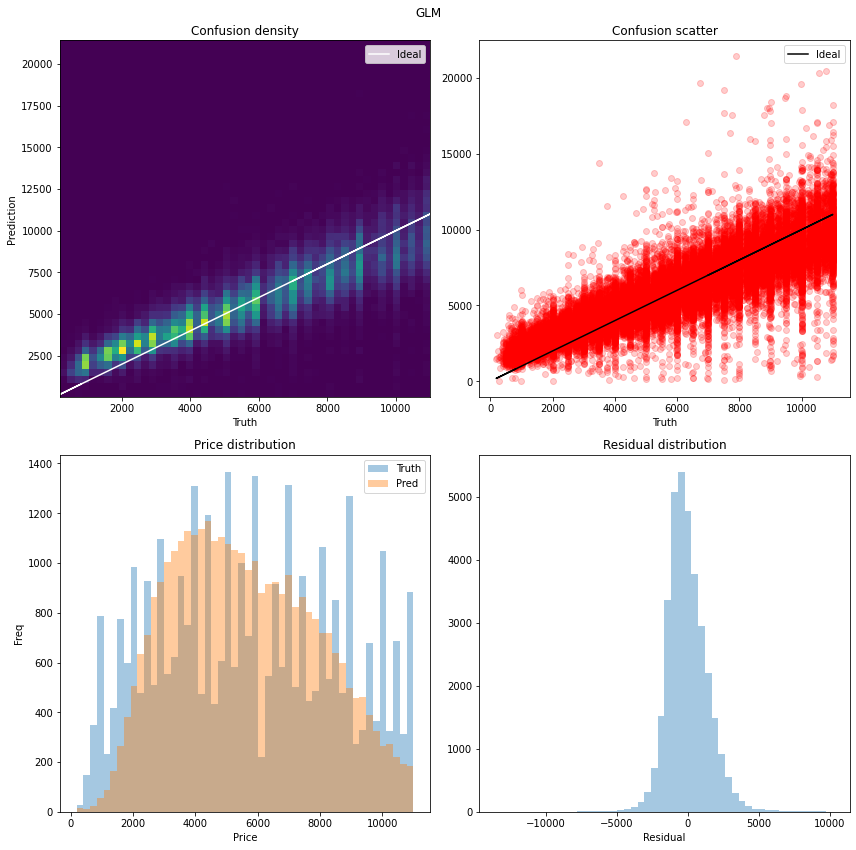

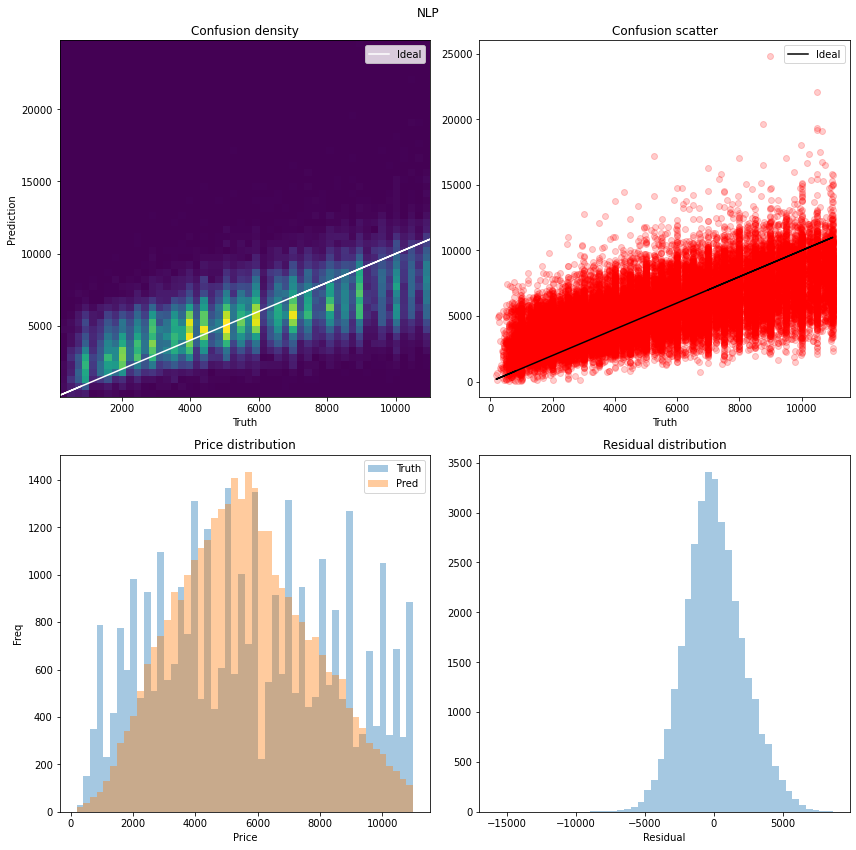

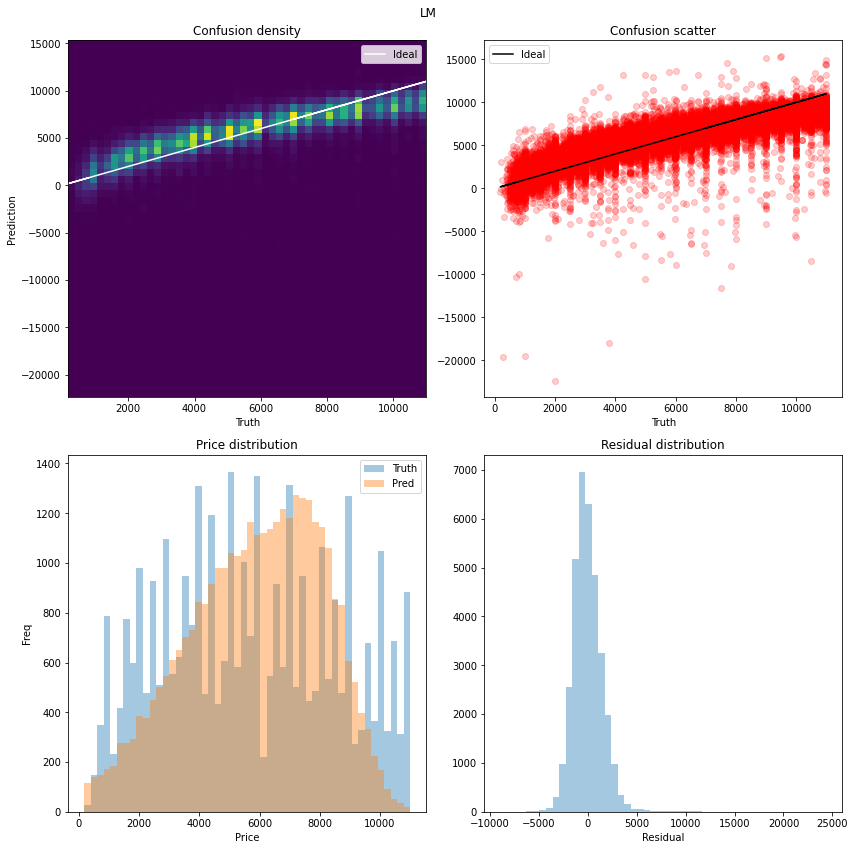

In [31]:
for method in set(pred_by_ad.index.get_level_values("method")):
    plot(pred_by_ad.loc[method]["price"], pred_by_ad.loc[method]["prediction"], method)